## **SPH 6004 Assignment 2_JLedit**

*Objective: To predict duration of intubation hours from time of admission to ICU. The dataset is from the MIMIC-IC Database.

## **1. IMPORT LIBRARIES**

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.impute import SimpleImputer
from datetime import timedelta

#for models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
#models
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import xgboost as xgb
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### 1.1. Load the datasets

In [10]:
# dynamic dataset
data_dynamic = pd.read_csv('sph_dynamic.csv')
data_dynamic.head()

,stay_id,charttime,total_protein,calcium,creatinine,glucose,sodium,chloride,heart_rate,sbp,...,ph,lactate,pt,urineoutput,sofa_respiration,sofa_coagulation,sofa_liver,sofa_cardiovascular,sofa_cns,sofa_renal
0,35715575,2148-12-27 18:15:00.000,NaN,8.5,0.9,137.0,138.0,104.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34483718,2118-01-04 03:58:00.000,NaN,8.2,0.8,129.0,141.0,101.0,NaN,NaN,...,NaN,NaN,12.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,31826892,2163-03-10 19:59:00.000,NaN,7.7,0.4,112.0,136.0,98.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,36154799,2131-12-02 19:14:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32732521,2116-08-12 12:45:00.000,NaN,NaN,4.0,135.0,139.0,105.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# static dataset
data_static = pd.read_csv('sph_static.csv')
data_static.head()

,stay_id,icu_intime,vent_start,vent_end,vent_duration
0,30004144,2126-04-04 13:20:25.000,4/5/26 16:00,4/6/26 17:00,25.000000
1,30005366,2202-12-27 17:36:59.000,12/28/02 14:00,12/28/02 20:00,6.000000
2,30006983,2159-10-12 03:56:42.000,10/12/59 18:00,10/14/59 19:00,49.000000
3,30023204,2124-07-09 16:43:55.000,7/11/24 16:00,7/12/24 16:10,24.166667
4,30031418,2156-03-05 14:11:00.000,3/7/56 22:06,3/8/56 8:00,9.900000


### 1.2. Clean up date and times + merge datasets

In [12]:
# merge the two datasets together ; many to one merge
data = pd.merge(data_dynamic, data_static, on = 'stay_id', how = 'left')
data = data.sort_values(by=['stay_id', 'charttime'], ascending=[True, True]) # sort by stay_id and charttime
data.head()

,stay_id,charttime,total_protein,calcium,creatinine,glucose,sodium,chloride,heart_rate,sbp,...,sofa_respiration,sofa_coagulation,sofa_liver,sofa_cardiovascular,sofa_cns,sofa_renal,icu_intime,vent_start,vent_end,vent_duration
4830,30004144,2126-04-04 09:30:00.000,NaN,8.0,0.7,114.0,135.0,103.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2126-04-04 13:20:25.000,4/5/26 16:00,4/6/26 17:00,25.0
3369,30004144,2126-04-04 13:06:00.000,NaN,6.8,0.7,133.0,135.0,102.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2126-04-04 13:20:25.000,4/5/26 16:00,4/6/26 17:00,25.0
6602,30005366,2202-12-28 02:10:00.000,NaN,8.8,6.7,41.0,139.0,100.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2202-12-27 17:36:59.000,12/28/02 14:00,12/28/02 20:00,6.0
2877,30006983,2159-10-11 13:20:00.000,NaN,8.0,0.8,156.0,132.0,102.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2159-10-12 03:56:42.000,10/12/59 18:00,10/14/59 19:00,49.0
374,30006983,2159-10-12 04:28:00.000,NaN,7.1,1.0,89.0,136.0,108.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2159-10-12 03:56:42.000,10/12/59 18:00,10/14/59 19:00,49.0


In [13]:
# clean up the date time format in static dataset [joseph's codes]
# Used Joseph's codes

data['icu_intime'] = pd.to_datetime(data['icu_intime'], format = "%Y-%m-%d %H:%M:%S.%f")

for i in range(len(data)):
        data.loc[i, 'vent_start'] = pd.Timestamp(data.loc[i, 'vent_start']).replace(year = data.loc[i, 'icu_intime'].year)

data['vent_end'] = data['vent_start'] + data['vent_duration'].apply(pd.Timedelta, unit='h')

data['icu_intime'] = pd.to_datetime(data['icu_intime'], format = "%Y-%m-%d %H:%M:%S.%f")
data['vent_start'] = pd.to_datetime(data['vent_start'], format = "%Y-%m-%d %H:%M:%S.%f")
data['vent_end'] = pd.to_datetime(data['vent_end'], format = "%Y-%m-%d %H:%M:%S.%f")
data['charttime'] = pd.to_datetime(data['charttime'], format = "%Y-%m-%d %H:%M:%S.%f")

# there are 13 records with 'vent_start' before 'icu_intime' (i.e. negative time difference)
# i need to change the  year in vent_start to next year with reference to icu_intime
for i in range(len(data)):
     if data.loc[i, 'vent_start'] < data.loc[i, 'icu_intime']:
         data.loc[i, 'vent_start'] = pd.Timestamp(data.loc[i, 'vent_start']).replace(year = data.loc[i, 'icu_intime'].year + 1)

for i in range(len(data)):
     if data.loc[i, 'vent_end'] < data.loc[i, 'icu_intime']:
         data.loc[i, 'vent_end'] = pd.Timestamp(data.loc[i, 'vent_end']).replace(year = data.loc[i, 'icu_intime'].year + 1)


# we will convert all timestamp columns into number of hours from 'icu_intime' of *each* patient.
# conversion for 'charttime'
data['charttime_hrs'] = (pd.to_datetime(data['charttime']) - pd.to_datetime(data['icu_intime']))/pd.Timedelta(hours=1)

# conversion for 'vent_start'.
# Note: time difference from 'icu_intime' to 'vent_start' is the engineered feature we wanted test as well.
# Note: conveniently, since all timestamp columns are converted into time difference from 'icu_intime', 
# there's no need to create another column for the engineered feature
data['vent_start_hrs'] = (pd.to_datetime(data['vent_start']) - pd.to_datetime(data['icu_intime']))/pd.Timedelta(hours=1)

data.to_excel('data.xlsx')

C:\Users\User\AppData\Local\Temp\ipykernel_14616\2175740363.py:9: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  data['vent_end'] = data['vent_start'] + data['vent_duration'].apply(pd.Timedelta, unit='h')


# **2. DATA EXPLORATION BEFORE ANY EXCLUSION OF PATIENTS**

### 2.1. Number of patients and records in the dataset

In [14]:
#print the number of unique patients in the dataset
print('Number of patients in the merged dataset: ', data['stay_id'].nunique())

#print the number of records in the dataset
print('Number of records in the merged dataset: ', data.shape[0])

Number of patients in the merged dataset:  1923
Number of records in the merged dataset:  7024


### 2.2. Mean and median no. of records per patient

In [15]:
# count the number of rows for each patient in the dataset 

# sort the data by patient and charttime
data = data.sort_values(by=['stay_id', 'charttime'], ascending=[True, True])

# generate a sequence number by patient and stay_id
data['seq'] = data.groupby([ 'stay_id']).cumcount() + 1

# generate the maximum no. of records per patient
seq_n = data.groupby('stay_id')['charttime'].transform('count')
data['seq_n'] = seq_n

# calculate the mean and median number of records per patient
mean_records = data.loc[data['seq'] == 1, 'seq_n'].mean()
median_records = data.loc[data['seq'] == 1, 'seq_n'].median()
print("Mean number of records per patient:", mean_records)
print("Median number of records per patient:", median_records)

# count the number of patients with n records 
freq = seq_n.value_counts().sort_index()
print('Statistics on number of records: ',freq)

Mean number of records per patient: 3.652626105044202
Median number of records per patient: 2.0
Statistics on number of records:  1       619
2      1296
3       774
4       428
5       245
6       252
7       196
8       176
9       234
10      200
11      132
12      120
13      117
14       56
15       45
16       64
17      136
18       72
19       57
20      100
21       21
22       88
23       46
24       48
25       75
26       26
27       27
28      224
29       58
30       30
31       31
33       66
38       38
39       39
40       40
41       82
44       44
46       46
49       49
61       61
62       62
82       82
93       93
133     133
196     196
Name: charttime, dtype: int64


### 2.3. Time till intubation

#### 2.3.1. Time betwen ICU admission and intubation

In [16]:
# calculate icu admission till intubation in hours
# data['icu_intubation_hrs'] = (data['vent_start'] - data['icu_intime']).dt.total_seconds()/3600
mean_records_icu = data.loc[data['seq'] == 1, 'vent_start_hrs'].mean()
median_records_icu = data.loc[data['seq'] == 1, 'vent_start_hrs'].median()
print("Mean time from icu admission to intubation:", mean_records_icu)
print("Median from icu admission to intubation:", median_records_icu)

Mean time from icu admission to intubation: 27.959311405789563
Median from icu admission to intubation: 23.966666666666665


#### 2.4.1. Time after intubation (hours)

Mean duration of intubation: 39.7960391749246
Median duration of intubation:  19.0
Minimum hours of intubation:  0.016666667
Maximum hours of intubation:  604.1666667


Text(0.5, 1.0, 'Histogram of vent duration')

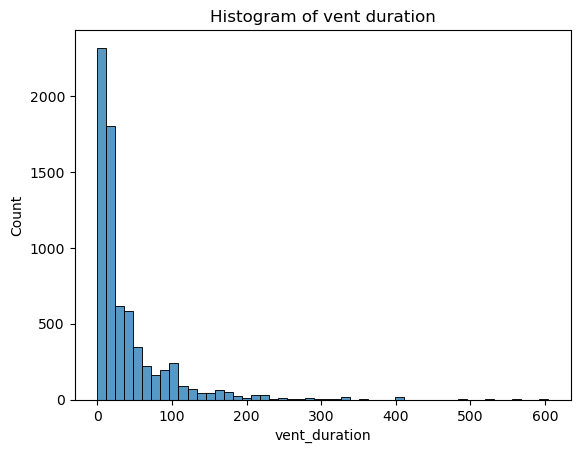

In [17]:
# mean and median time of intubation
mean_records_icu = data.loc[data['seq'] == 1, 'vent_duration'].mean()
median_records_icu = data.loc[data['seq'] == 1, 'vent_duration'].median()
print("Mean duration of intubation:", mean_records_icu)
print('Median duration of intubation: ', median_records_icu)
print('Minimum hours of intubation: ', data['vent_duration'].min())
print('Maximum hours of intubation: ', data['vent_duration'].max())

#plot histogram for vent duration
sns.histplot(data, x='vent_duration', bins=50)
plt.title('Histogram of vent duration')

# **3A. XGboost** - model all

### 3.1. Number of patients to include in final dataset
1. Exclude patients that were intubated 48 hours after ICU admission 

In [18]:
# earliest and latest charttime before and after icu admission
print('Earliest charttime before icu admission: ', data[data['charttime_hrs'] < 0]['charttime_hrs'].min())
print('Latest charttime before icu admission: ', data[data['charttime_hrs'] < 0]['charttime_hrs'].max())
print('Earliest charttime after icu admission: ', data[data['charttime_hrs'] > 0]['charttime_hrs'].min())
print('Latest charttime after icu admission: ', data[data['charttime_hrs'] > 0]['charttime_hrs'].max())

# number of patients and records were intubated 48 hours after ICU admission
print('Number of patients intubated >48 hrs : ', data[data['vent_start_hrs'] > 48]['stay_id'].nunique())
print('Number of records intubated >48 hrs : ', data[data['vent_start_hrs'] > 48]['stay_id'].count())

# exclude patients who were intubated 48 hours after ICU admission 
data_2 = data[data['vent_start_hrs'] < 48].copy()
print('Number of patients afer exclude >48 hrs : ', data_2['stay_id'].nunique())
print('Number of records after exclude >48 hrs :', data_2.shape[0])


Earliest charttime before icu admission:  -3597.2272222222223
Latest charttime before icu admission:  -0.011944444444444445
Earliest charttime after icu admission:  0.0030555555555555557
Latest charttime after icu admission:  12.0
Number of patients intubated >48 hrs :  193
Number of records intubated >48 hrs :  880
Number of patients afer exclude >48 hrs :  1730
Number of records after exclude >48 hrs : 6144


### 3.2. Mean and median no. of records per patient

In [19]:
# count the number of rows for each patient in the dataset 

# sort the data by patient and charttime
data_2 = data_2.sort_values(by=['stay_id', 'charttime'], ascending=[True, True])

# generate a sequence number by patient and stay_id
data_2['seq'] = data_2.groupby([ 'stay_id']).cumcount() + 1

# generate the maximum no. of records per patient
seq_n = data_2.groupby('stay_id')['charttime'].transform('count')
data_2['seq_n'] = seq_n

# calculate the mean and median number of records per patient
mean_records = data_2.loc[data['seq'] == 1, 'seq_n'].mean()
median_records = data_2.loc[data['seq'] == 1, 'seq_n'].median()
print("Mean number of records per patient:", mean_records)
print("Median number of records per patient:", median_records)

# count the number of patients with n records 
freq = seq_n.value_counts().sort_index()
print('Statistics on number of records: ',freq)

Mean number of records per patient: 3.5514450867052023
Median number of records per patient: 2.0
Statistics on number of records:  1       557
2      1192
3       696
4       384
5       210
6       210
7       189
8       160
9       171
10      180
11       99
12      108
13      104
14       56
15       45
16       48
17      102
18       54
19       57
20       80
21       21
22       88
23       23
24       48
25       75
26       26
27       27
28      224
29       29
30       30
31       31
33       33
38       38
39       39
40       40
41       41
46       46
49       49
61       61
62       62
82       82
133     133
196     196
Name: charttime, dtype: int64


### 3.3. Time after intubation

Mean duration of intubation:  39.66579961472313
Standard deviation of intubation:  57.87672100350697
Median duration of intubation:  19.0
Minimum hours of intubation:  0.016666667
Maximum hours of intubation:  604.1666667


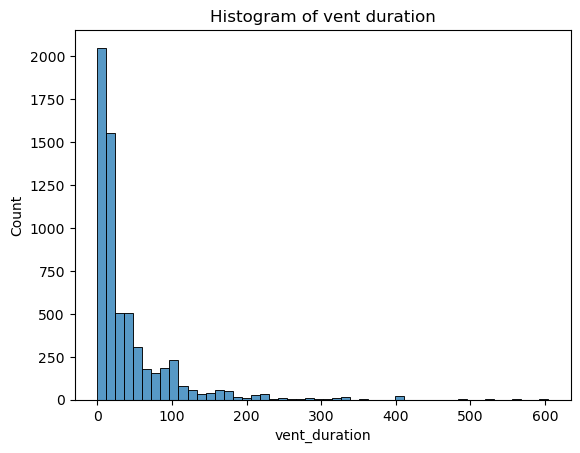

In [20]:
# mean and median time of intubation
mean_records_icu = data_2.loc[data['seq'] == 1, 'vent_duration'].mean()
sd_records_icu = data_2.loc[data['seq'] == 1, 'vent_duration'].std()
median_records_icu = data_2.loc[data['seq'] == 1, 'vent_duration'].median()
print('Mean duration of intubation: ', mean_records_icu)
print('Standard deviation of intubation: ', sd_records_icu)
print('Median duration of intubation: ',median_records_icu)
print('Minimum hours of intubation: ', data_2['vent_duration'].min())
print('Maximum hours of intubation: ', data_2['vent_duration'].max())

#plot histogram for vent duration
sns.histplot(data_2, x='vent_duration', bins=50)
plt.title('Histogram of vent duration')

data_2.to_excel('data_2.xlsx', index=False)

### 3.4. Assess % missing values

In [21]:
# asssess missing values by variables in the dataset

def count_missing(x):
    count = x.isnull().sum()
    percent = round(count / len(x) * 100,1)
    return pd.Series({'missing_count': count, 'missing_percent': percent})

table1 = data_2.agg({col: count_missing for col in data_2.columns[1:]}).T
table1_sorted = table1.sort_values(ascending=True, by='missing_percent')
# save to excel 
table1_sorted.to_excel('missing_values.xlsx') 
print(table1_sorted)

                     missing_count  missing_percent
charttime                      0.0              0.0
vent_start_hrs                 0.0              0.0
charttime_hrs                  0.0              0.0
vent_duration                  0.0              0.0
vent_end                       0.0              0.0
vent_start                     0.0              0.0
icu_intime                     0.0              0.0
seq                            0.0              0.0
seq_n                          0.0              0.0
sodium                       185.0              3.0
chloride                     204.0              3.3
creatinine                   213.0              3.5
glucose                      357.0              5.8
calcium                      798.0             13.0
hemoglobin                  1008.0             16.4
wbc                         1029.0             16.7
pt                          2680.0             43.6
ast                         3478.0             56.6
alt         

### 3.5. Drop columns with > 40% missing values

In [22]:
# Drop columns with missing percentage greater than 40
missing_threshold = 40
cols_to_drop = table1_sorted[table1_sorted['missing_percent'] > missing_threshold].index
data_2.drop(cols_to_drop, axis=1, inplace=True)

# save to excel
data_2.to_excel('data_2.xlsx', index=False)

In [23]:
# drop unwanted variables 
data_2 = data_2.drop(['icu_intime','vent_start', 'vent_end', 'seq', 'seq_n', 'vent_start_hrs', 'charttime'], axis=1)

# move vent_duration to the end of the dataframe
data_2 = data_2[['stay_id', 'calcium', 'creatinine', 'glucose', 'sodium', 'chloride', 'hemoglobin', 'wbc', 
                            'charttime_hrs', 'vent_duration']]

data_2.head()

,stay_id,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,charttime_hrs,vent_duration
4830,30004144,8.0,0.7,114.0,135.0,103.0,13.0,5.1,-3.840278,25.0
3369,30004144,6.8,0.7,133.0,135.0,102.0,11.8,4.8,-0.240278,25.0
6602,30005366,8.8,6.7,41.0,139.0,100.0,9.2,9.4,8.550278,6.0
2877,30006983,8.0,0.8,156.0,132.0,102.0,10.1,8.2,-14.611667,49.0
374,30006983,7.1,1.0,89.0,136.0,108.0,NaN,NaN,0.521667,49.0


### 3.6. Data visualisation of the variables (raw data)

In [24]:
# get min and max of calcium, creatinine, glucose, sodium, chloride, hemoglobin, wbc
data_2[['calcium', 'creatinine', 'glucose', 'sodium', 'chloride', 'hemoglobin', 'wbc']].describe().T

,count,mean,std,min,25%,50%,75%,max
calcium,5346.0,8.394295,0.822929,4.2,7.9,8.4,8.9,12.3
creatinine,5931.0,1.639015,1.846295,0.1,0.7,1.1,1.8,19.7
glucose,5787.0,142.088820,92.784483,30.0,101.0,124.0,158.0,2970.0
sodium,5959.0,137.301225,5.719737,83.0,134.0,138.0,141.0,185.0
chloride,5940.0,101.939226,6.822369,62.0,98.0,102.0,106.0,153.0
hemoglobin,5136.0,10.054322,2.188325,3.9,8.3,9.8,11.4,18.3
wbc,5115.0,11.155718,8.277822,0.1,6.1,9.5,14.3,125.2


C:\Users\User\AppData\Local\Temp\ipykernel_14616\3554765300.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=x[i], data=data_2, ax=ax,palette='Set2')
C:\Users\User\AppData\Local\Temp\ipykernel_14616\3554765300.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=x[i], data=data_2, ax=ax,palette='Set2')
C:\Users\User\AppData\Local\Temp\ipykernel_14616\3554765300.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=x[i], data=data_2, ax=ax,palette='Set2')
C:\Users\User\AppData\Local\Temp\ipykernel_14616\3554765300.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=x[i], data=data_2, ax=ax,palette='Set2')
C:\Users\User\AppData\Local\Temp\ipykernel_14616\3554765300.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=x[i], data=data_2, ax=ax,palett

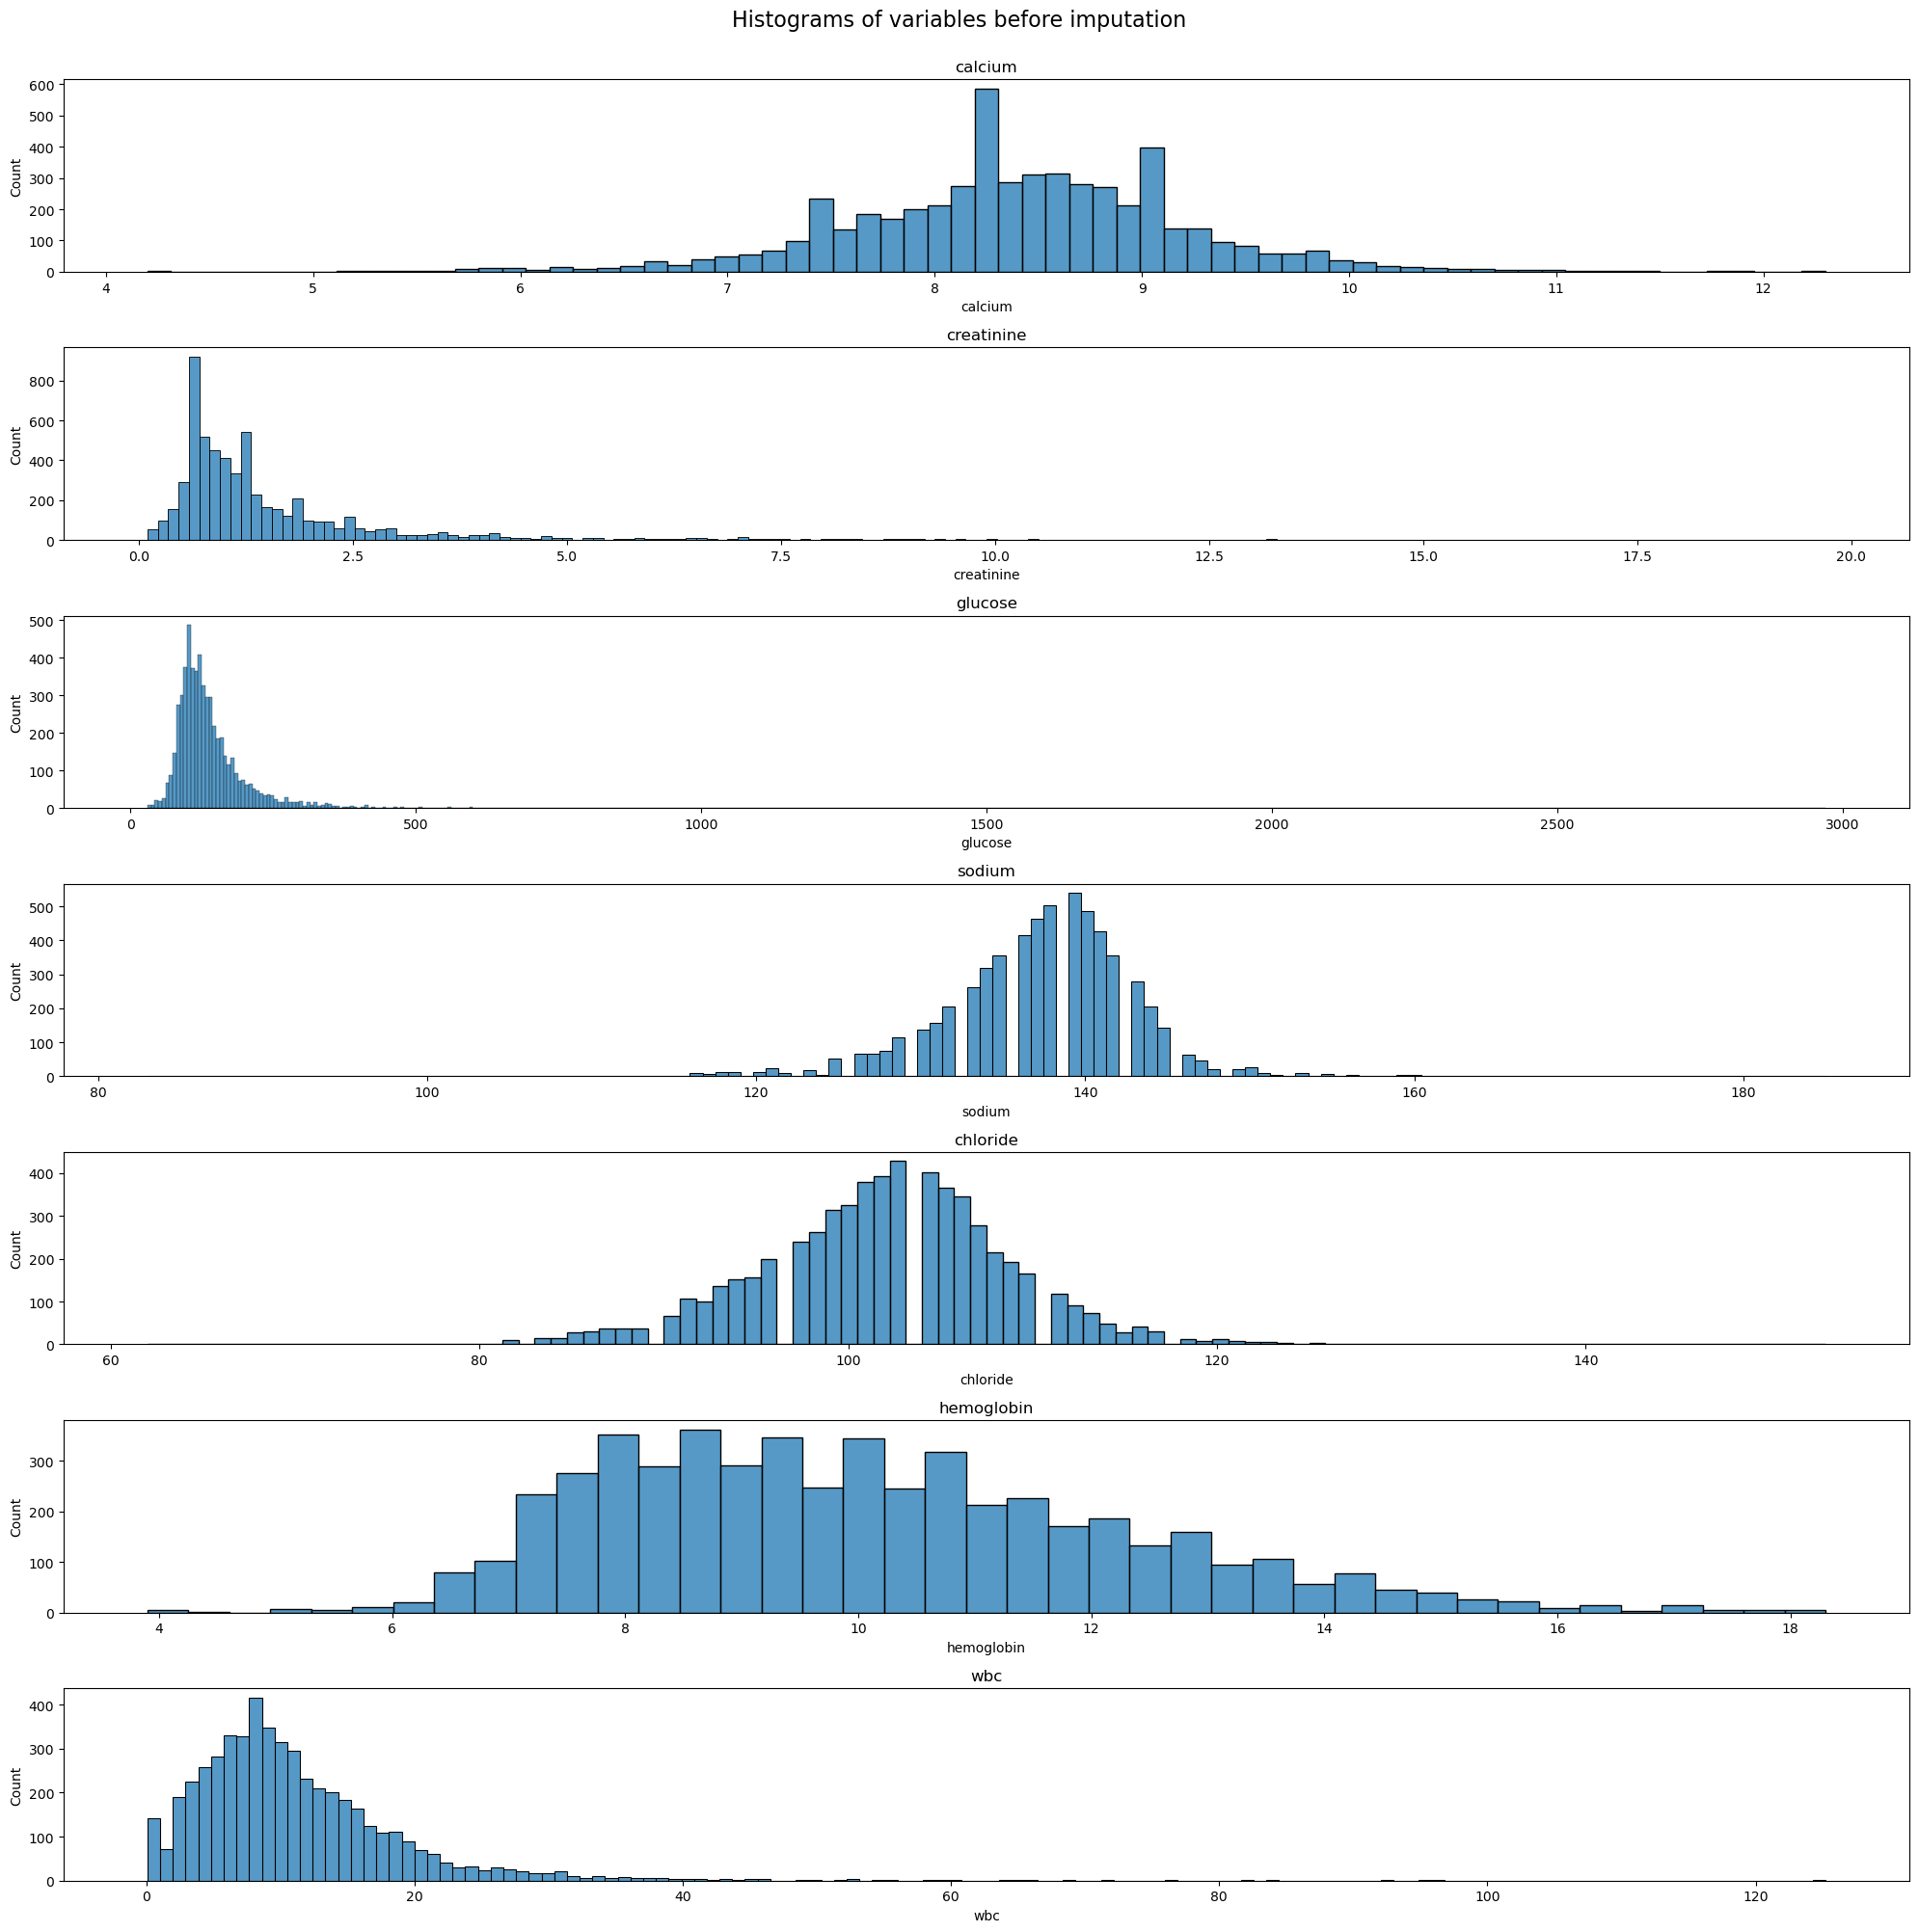

In [25]:
# specify x variables to plot using boxplots
x = data_2.loc[:, 'calcium':'wbc'].columns

# plot separate histograms for each variable (minus outcome) in a grid
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(20, 20))
fig.suptitle('Histograms of variables before imputation', fontsize=16, y=1.0)
fig.subplots_adjust(hspace=0.5, wspace=0.5) #adjust space between the plots
for i, ax in enumerate(axes.flatten()):
    if i < 7:
        sns.histplot(x=x[i], data=data_2, ax=ax,palette='Set2')
        ax.set_title(x[i])
        ax.set_xlabel(x[i])
        ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

### **3.7. Split the dataset, impute and scale**

In [26]:
## create the functions for median impute and min max 
# Median impute function based on scikit package
def imputeMedian(dataframe):
    numeric_cols = dataframe.select_dtypes(include=np.number).columns.tolist()
    df = dataframe.copy()
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    df[numeric_cols] = imp_median.fit_transform(df[numeric_cols])
    return df

# Min Max scaling function based on scikit package
def minMaxScale(dataframe):
    df = dataframe.values
    df = minmax_scale(df, feature_range=(0, 1), axis=0, copy=True)
    # put back the column label
    df = pd.DataFrame(df, columns = list(dataframe.columns))
    return df

In [27]:
# Get all unique patients 
unique_values = data_2['stay_id'].unique().tolist()

# Set the random seed for reproducibility
np.random.seed(42)

# Randomly split 70% of the unique values into a train list and the remaining 30% into a test list
train_size = int(0.7 * len(unique_values))
train = np.random.choice(unique_values, size=train_size, replace=False).tolist()
test = [value for value in unique_values if value not in train]

# Split the DataFrame into train and test DataFrames based on the values of stay_id
train_all_df = data_2[data_2['stay_id'].isin(train)].reset_index(drop = True).sort_values(['stay_id', 'charttime_hrs'])
test_all_df = data_2[data_2['stay_id'].isin(test)].reset_index(drop = True).sort_values(['stay_id', 'charttime_hrs'])

# Median impute for train. Median impute for test
train_all_df = imputeMedian(train_all_df)
test_all_df = imputeMedian(test_all_df)

#number of patients and records in train set
print('Number of patients train set:', train_all_df['stay_id'].nunique())
print('Number of records train set:', train_all_df.shape[0])
# mean, median, and range of vent_duration in train set for unique patients
print('Mean of vent_duration train set:', train_all_df['vent_duration'].mean())
print('Median of vent_duration train set:', train_all_df['vent_duration'].median())
print('Range of vent_duration train set:', train_all_df['vent_duration'].min(), train_all_df['vent_duration'].max())

# number of patients and records in the test set
print('Number of patients test set:', test_all_df['stay_id'].nunique())
print('Number of records test set:', test_all_df.shape[0])
# mean, median, and range of vent_duration in test set for unique patients
print('Mean of vent_duration test set:', test_all_df['vent_duration'].mean())
print('Median of vent_duration test set:', test_all_df['vent_duration'].median())
print('Range of vent_duration test set:', test_all_df['vent_duration'].min(), test_all_df['vent_duration'].max())

# Min Max scaling for train. Min Max scaling for test
train_all_df_scaled = minMaxScale(train_all_df)
test_all_df_scaled = minMaxScale(test_all_df)

print('Train_100 DataFrame:')
print(train_all_df)
print()
print('Train_100 Min Max scaled DataFrame:')
print(train_all_df_scaled)
print()

print('Test_100 DataFrame:')
print(test_all_df)
print()
print('Test_100 Min Max scaled DataFrame:')
print(test_all_df_scaled)

# i want to save train and test datasets with stay id into excel file
train_all_df.to_excel('train_df.xlsx')
test_all_df.to_excel('test_df.xlsx')

Number of patients train set: 1211
Number of records train set: 4399
Mean of vent_duration train set: 40.81268470100545
Median of vent_duration train set: 19.3
Range of vent_duration train set: 0.016666667 604.1666667
Number of patients test set: 519
Number of records test set: 1745
Mean of vent_duration test set: 39.70914040107736
Median of vent_duration test set: 18.23333333
Range of vent_duration test set: 0.2 564.0
Train_100 DataFrame:
         stay_id  calcium  creatinine  glucose  sodium  chloride  hemoglobin  \
0     30004144.0      8.0         0.7    114.0   135.0     103.0        13.0   
1     30004144.0      6.8         0.7    133.0   135.0     102.0        11.8   
2     30006983.0      8.0         0.8    156.0   132.0     102.0        10.1   
3     30006983.0      7.1         1.0     89.0   136.0     108.0         9.7   
4     30023204.0      8.2         1.6    124.0   130.0     100.0         8.3   
...          ...      ...         ...      ...     ...       ...         ...

### **3.8. Run the model**

1. use scaled x data and  y data [ as per joseph's codes]

In [47]:
x_train = train_all_df[['calcium', 'creatinine', 'glucose', 'sodium', 'chloride', 'hemoglobin', 'wbc', 'charttime_hrs' ]]
y_train = train_all_df['vent_duration']

x_test = test_all_df[['calcium', 'creatinine', 'glucose', 'sodium', 'chloride', 'hemoglobin', 'wbc', 'charttime_hrs']]
y_test = test_all_df['vent_duration']

# Define the parameters for the XGBoost model
params = {
    'objective': ['reg:squarederror'],   # Use mean squared error as the objective function
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'alpha': [1, 5, 10],
    'n_estimators': [100, 200, 300]
}

# Create  XGBoost model
model = xgb.XGBRegressor()

# Create GridSearchCV function
cv=TimeSeriesSplit()
grid_search = GridSearchCV(estimator=model, param_grid=params, cv=cv)

# create pipeline to scale the data using min max scaler and use grid search to find the best parameters
pipeline = Pipeline(steps=[('scaler', MinMaxScaler()), ('xgb', grid_search)])

regressor = TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())

# Fit the regressor on the training data
regressor.fit(x_train, y_train)

# Get the best parameters from the grid search object of the pipeline
best_params = regressor.regressor_.named_steps['xgb'].best_params_

# Print the best parameters
print("Best parameters:", best_params)

# Make predictions on the test set using the best model
y_pred = regressor.predict(x_test)
y_pred_inverse = regressor.transformer_.inverse_transform(y_pred.reshape(-1, 1))

scaler = MinMaxScaler()
scaler.fit(y_test.values.reshape(-1, 1))
y_test_transformed = scaler.transform(y_test.values.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test_transformed)

# Evaluate model performance at record level
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print( 'R2:', metrics.r2_score(y_test, y_pred))

print('RMSE = ' + str(mean_squared_error(y_test, y_pred, squared = False)))

NameError: name 'TransformedTargetRegressor' is not defined

   vent_duration  pred_median  pred_lower  pred_upper
0           6.00    86.252640   13.492583   70.051984
1          20.45    35.172466    8.162465   71.799499
2          20.45    33.341492    6.622431  116.176937
3          20.45    35.172466    8.544197   76.142394
4          20.45    35.172466    7.793111   95.964444
Mean Absolute Error: 38.173945083336946
Mean Squared Error: 4492.931911023751
Root Mean Squared Error: 67.02933619709918
R2: -0.04743860655369847
RMSE = 67.02933619709918


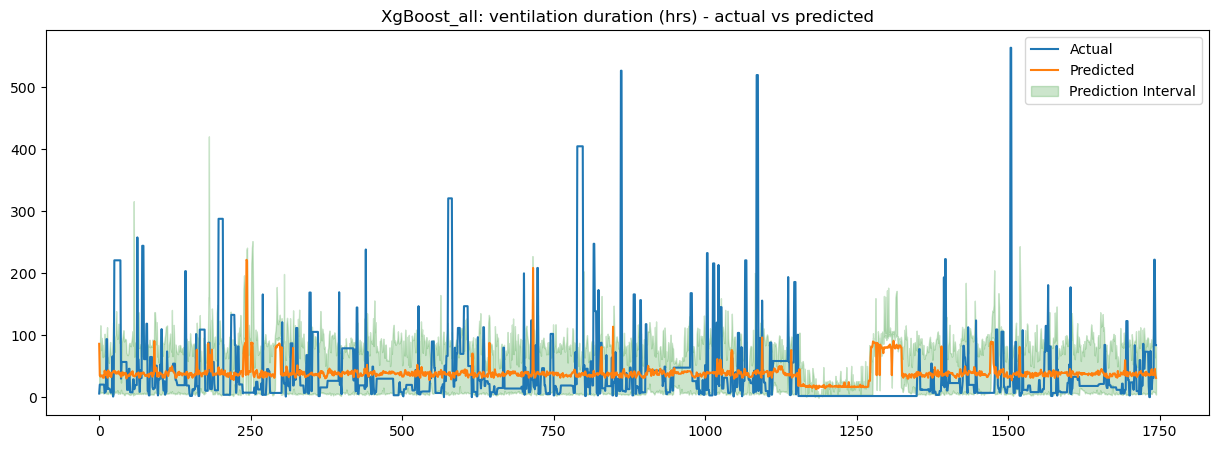

In [48]:
alpha = 0.1

## Predict lower bound
lower_pipeline = Pipeline([('scaler', MinMaxScaler()), ('lower_model', GradientBoostingRegressor(loss="quantile", alpha=alpha, n_estimators=100, max_depth=10))])

## Predict upper bound
upper_pipeline = Pipeline([('scaler', MinMaxScaler()), ('upper_model', GradientBoostingRegressor(loss="quantile", alpha=1-alpha, n_estimators=100, max_depth=10))])

## Predict median
median_pipeline = Pipeline([('scaler', MinMaxScaler()), ('median_model', xgb.XGBRegressor(objective='reg:squarederror', learning_rate=best_params['learning_rate'], max_depth=best_params['max_depth'], alpha=best_params['alpha'], n_estimators=best_params['n_estimators']))])

lower_pipeline.fit(x_train, y_train)
upper_pipeline.fit(x_train, y_train)
median_pipeline.fit(x_train, y_train)

pred_lower = lower_pipeline.predict(x_test)
pred_upper = upper_pipeline.predict(x_test)
pred_median = median_pipeline.predict(x_test)

predictions = pd.DataFrame(y_test)
predictions['pred_median'] = pred_median
predictions['pred_lower'] = pred_lower
predictions['pred_upper'] = pred_upper
print(predictions.head())

# Evaluate model performance at record level
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred_median))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred_median))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred_median)))
print('R2:', metrics.r2_score(y_test, pred_median))

print('RMSE = ' + str(mean_squared_error(y_test, pred_median, squared=False)))

# Plot expected vs actual with upper and lower bounds
plt.figure(figsize = (15, 5))
plt.plot(y_test, label='Actual')
plt.plot(pred_median, label='Predicted')
plt.fill_between(y_test.index, pred_lower, pred_upper, alpha=0.2, color='green', label='Prediction Interval')
plt.title("XgBoost_all: ventilation duration (hrs) - actual vs predicted")
plt.legend()
plt.show()

RMSE = 67.81442202693695


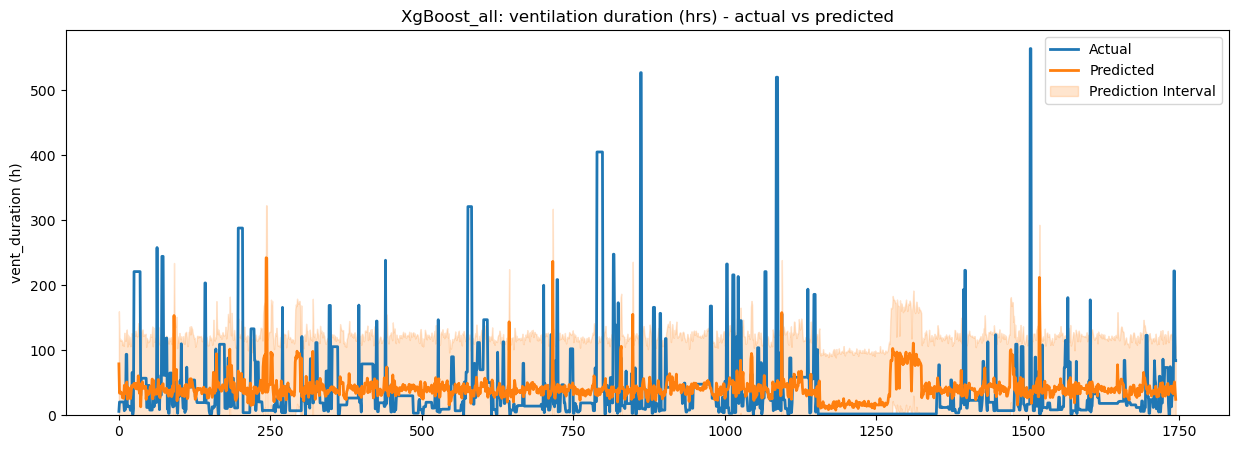

## Feature scores ##

wbc : 43876.375
calcium : 29688.865234375
hemoglobin : 24517.267578125
glucose : 23426.6640625
charttime_hrs : 21649.548828125
creatinine : 18052.123046875
sodium : 16837.9296875
chloride : 13895.48046875

## Shapley Additive Explanations - SHAP value ##



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


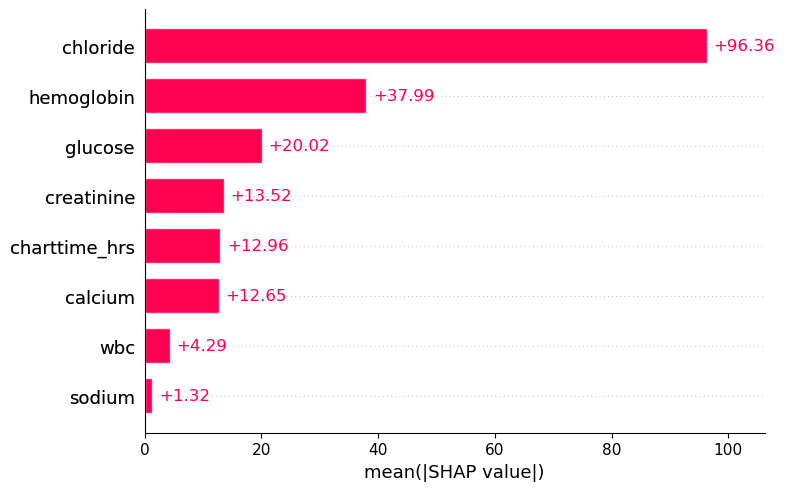

          y_test     y_pred   lower_pi    upper_pi
0       6.000000  79.091125  -1.763107  159.945358
1      20.450000  34.000687 -46.853546  114.854919
2      20.450000  36.853798 -44.000435  117.708031
3      20.450000  34.000687 -46.853546  114.854919
4      20.450000  35.042953 -45.811279  115.897186
...          ...        ...        ...         ...
1740   31.266667  32.920761 -47.933472  113.774994
1741  222.000000  46.547771 -34.306461  127.402004
1742  222.000000  51.413784 -29.440449  132.268017
1743   84.000000  36.208389 -44.645844  117.062622
1744   84.000000  24.489416 -56.364817  105.343649

[1745 rows x 4 columns]
      index      y_test     y_pred   lower_pi    upper_pi  index_copy
0       615    0.200000  35.311199 -45.543034  116.165432         615
1      1733    0.216667  34.949894 -45.904339  115.804127        1733
2      1734    0.216667  39.116287 -41.737946  119.970520        1734
3       569    0.266667  48.688187 -32.166046  129.542419         569
4       645  

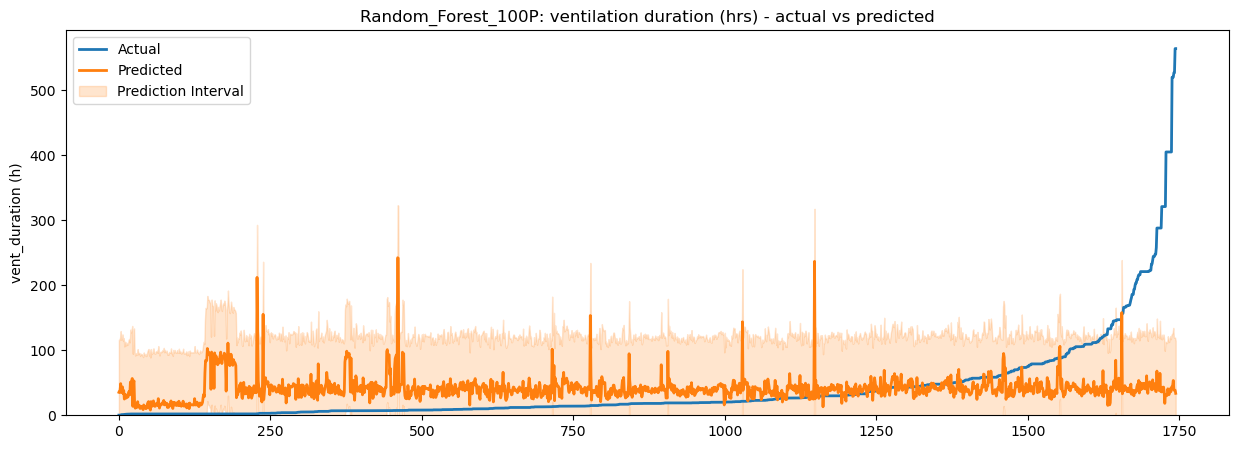

In [49]:
## JL edit


from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.regression import MapieRegressor
from mapie.quantile_regression import MapieQuantileRegressor

best_params = {'alpha': 10, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror'}

## Predict median
median_pipeline = Pipeline([('scaler', MinMaxScaler()), ('median_model', xgb.XGBRegressor(objective='reg:squarederror', learning_rate=best_params['learning_rate'], max_depth=best_params['max_depth'], alpha=best_params['alpha'], n_estimators=best_params['n_estimators']))])
median_pipeline.fit(x_train, y_train)
pred_median = median_pipeline.predict(x_test)


# Evaluate model performance at record level


print('RMSE = ' + str(mean_squared_error(y_test, pred_median, squared=False)))

# Plot estimated prediction intervals on test set

mapie = MapieRegressor(
    median_pipeline, method="naive", cv=TimeSeriesSplit(), agg_function=None, n_jobs=-1
)

mapie.fit(x_train, y_train)
pred_median, y_pis = mapie.predict(x_test, alpha=0.05)
coverage = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])
width = regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0])


fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
plt.ylabel("vent_duration (h)")
ax.plot(y_test, lw=2, label="Actual", c="C0")
ax.plot(y_test.index, pred_median, lw=2, c="C1", label="Predicted")
ax.set_ylim(bottom=0)
ax.fill_between(
    y_test.index,
    y_pis[:, 0, 0],
    y_pis[:, 1, 0],
    color="C1",
    alpha=0.2,
    label="Prediction Interval",
)
plt.title("XgBoost_all: ventilation duration (hrs) - actual vs predicted")
ax.legend()
plt.show()



print("## Feature scores ##")
print()
#‘weight’: the number of times a feature is used to split the data across all trees.
#‘gain’: the average gain across all splits the feature is used in.
feature_importance = median_pipeline[1].get_booster().get_score(importance_type='gain')
feature = median_pipeline[1].get_booster().feature_types

keys = list(feature_importance.keys())
values = list(feature_importance.values())

sorted_feature_importance = []
for i in range(len(feature_importance)):
    sorted_feature_importance.append((keys[i],values[i]))

sorted_feature_importance = sorted(sorted_feature_importance, reverse=True, key=lambda feature: feature[1])
for i in sorted_feature_importance:
    print(i[0],":", i[1])
print()

import shap
print("## Shapley Additive Explanations - SHAP value ##")
print()
explainer = shap.Explainer(median_pipeline[1])
shap_values = explainer(x_test)
shap.plots.bar(shap_values, max_display=12) # default is max_display=12

# please replace the y_test, y_pred, and y_pis to match the variable names in your code. 
y_test_df = pd.DataFrame({'y_test': y_test})
y_pred_df = pd.DataFrame({'y_pred': pred_median})
y_pis = np.reshape(y_pis, (y_pis.shape[0],2)) 
y_pis_df = pd.DataFrame(y_pis, columns=['lower_pi', 'upper_pi'])

# please replace output with a name of your model and the vent_duration percentile. 
output = pd.concat([y_test_df, y_pred_df, y_pis_df], axis=1) 
print(output)
output['index_copy'] = output.index
output = output.sort_values(by=['y_test', 'index_copy']).reset_index().copy(deep=True)
print(output)




# Plot estimated prediction intervals on test set

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
plt.ylabel("vent_duration (h)")
ax.plot(output['y_test'], lw=2, label="Actual", c="C0")
ax.plot(output.index, output['y_pred'], lw=2, c="C1", label="Predicted")
ax.set_ylim(bottom=0)
ax.fill_between(
    output.index,
    output['lower_pi'],
    output['upper_pi'],
    color="C1",
    alpha=0.2,
    label="Prediction Interval")
plt.title("Random_Forest_100P: ventilation duration (hrs) - actual vs predicted")
ax.legend()
plt.show()

In [67]:
# please replace the y_test, y_pred, and y_pis to match the variable names in your code. 
y_test_df = pd.DataFrame({'y_test': y_test})
y_pred_df = pd.DataFrame({'y_pred': pred_median})
y_pis = np.reshape(y_pis, (y_pis.shape[0],2)) 
y_pis_df = pd.DataFrame(y_pis, columns=['lower_pi', 'upper_pi'])

# please replace output with a name of your model and the vent_duration percentile. e.g."randomforest_90_output"
svm_100_output = pd.concat([y_test_df, y_pred_df, y_pis_df], axis=1)
print(svm_100_output)
svm_100_output.to_csv('svm_100_output.csv')

      y_test     y_pred   lower_pi   upper_pi
0       6.00  32.620480 -14.980665  80.221624
1      20.45  21.827065 -25.774080  69.428209
2      20.45  22.254652 -25.346492  69.855796
3      20.45  23.023392 -24.577752  70.624536
4      20.45  22.827707 -24.773437  70.428851
...      ...        ...        ...        ...
1872     NaN  28.609293 -18.991851  76.210437
1873     NaN  27.579227 -20.021917  75.180372
1874     NaN  23.482189 -24.118955  71.083333
1875     NaN  21.966307 -25.634837  69.567451
1876     NaN  21.966307 -25.634837  69.567451

[1877 rows x 4 columns]


# **4. XGboost** -  model 90th percentile
### 4.1. Number of patients to include in final dataset
1. Exclude patients that were intubated 48 hours after ICU admission 
3. remove patients with vent_duration in the top 10% of the dataset

In [50]:
# earliest and latest charttime before and after icu admission
print('Earliest charttime before icu admission: ', data[data['charttime_hrs'] < 0]['charttime_hrs'].min())
print('Latest charttime before icu admission: ', data[data['charttime_hrs'] < 0]['charttime_hrs'].max())
print('Earliest charttime after icu admission: ', data[data['charttime_hrs'] > 0]['charttime_hrs'].min())
print('Latest charttime after icu admission: ', data[data['charttime_hrs'] > 0]['charttime_hrs'].max())

# number of patients and records were intubated 48 hours after ICU admission
print('Number of patients intubated >48 hrs : ', data[data['vent_start_hrs'] > 48]['stay_id'].nunique())
print('Number of records intubated >48 hrs : ', data[data['vent_start_hrs'] > 48]['stay_id'].count())

# exclude patients who were intubated 48 hours after ICU admission 
data_2b = data[data['vent_start_hrs'] < 48].copy()
print('Number of patients afer exclude >48 hrs : ', data_2b['stay_id'].nunique())
print('Number of records after exclude >48 hrs :', data_2b.shape[0])

# vent duration distribution by percentile for unique patients
print(data_2b['vent_duration'].describe(percentiles=[.1, .25, .5, .75, .9, 0.95]))

threshold = 104.133333

# print number of patients and records with vent duration > threshold
print('Number of patients with vent duration > 104 hours: ', data_2b[data_2b['vent_duration'] > threshold]['stay_id'].nunique())
print('Number of records with vent duration > 104 hours: ', data_2b[data_2b['vent_duration'] > threshold]['stay_id'].count())

# keep patients and records with vent duration <= threshold
data_2b = data_2b[data_2b['vent_duration'] <= threshold]

# print number of patients and records with chartime after ICU admission
print('Number of patients: ', data_2b['stay_id'].nunique())
print('Number of records: ', data_2b.shape[0])


Earliest charttime before icu admission:  -3597.2272222222223
Latest charttime before icu admission:  -0.011944444444444445
Earliest charttime after icu admission:  0.0030555555555555557
Latest charttime after icu admission:  12.0
Number of patients intubated >48 hrs :  193
Number of records intubated >48 hrs :  880
Number of patients afer exclude >48 hrs :  1730
Number of records after exclude >48 hrs : 6144
count    6144.000000
mean       40.499259
std        57.580977
min         0.016667
10%         4.000000
25%         8.066667
50%        19.000000
75%        48.333333
90%       104.133333
95%       146.770000
max       604.166667
Name: vent_duration, dtype: float64
Number of patients with vent duration > 104 hours:  153
Number of records with vent duration > 104 hours:  644
Number of patients:  1577
Number of records:  5500


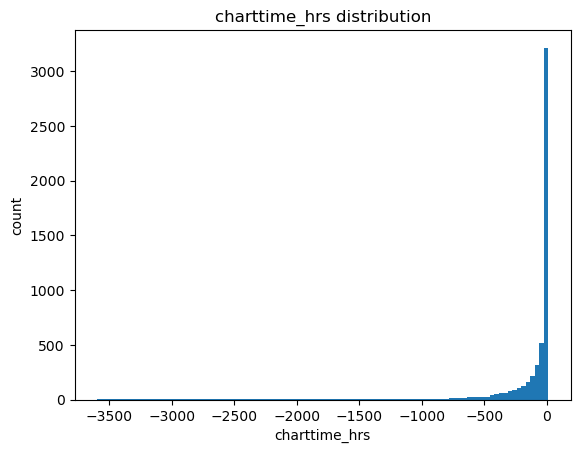

In [51]:
#plot charttime_hrs distribution
plt.hist(data_2b['charttime_hrs'], bins=100)
plt.xlabel('charttime_hrs')
plt.ylabel('count')
plt.title('charttime_hrs distribution')
plt.show()

### 4.2. Mean and median no. of records per patient

In [52]:
# count the number of rows for each patient in the dataset 

# sort the data by patient and charttime
data_2b = data_2b.sort_values(by=['stay_id', 'charttime'], ascending=[True, True])

# generate a sequence number by patient and stay_id
data_2b['seq'] = data_2b.groupby([ 'stay_id']).cumcount() + 1

# generate the maximum no. of records per patient
seq_n = data_2b.groupby('stay_id')['charttime'].transform('count')
data_2b['seq_n'] = seq_n

# calculate the mean and median number of records per patient
mean_records = data_2b.loc[data['seq'] == 1, 'seq_n'].mean()
median_records = data_2b.loc[data['seq'] == 1, 'seq_n'].median()
print("Mean number of records per patient:", mean_records)
print("Median number of records per patient:", median_records)

# count the number of patients with n records 
freq = seq_n.value_counts().sort_index()
print('Statistics on number of records: ',freq)

Mean number of records per patient: 3.4876347495244135
Median number of records per patient: 2.0
Statistics on number of records:  1       520
2      1080
3       624
4       352
5       185
6       204
7       154
8       144
9       135
10      150
11       88
12      108
13       91
14       56
15       45
16       48
17      102
18       36
19       57
20       80
21       21
22       88
24       48
25       75
26       26
27       27
28      196
29       29
30       30
31       31
33       33
38       38
40       40
41       41
46       46
61       61
82       82
133     133
196     196
Name: charttime, dtype: int64


### 4.3. Time after intubation

Mean vent duration:  25.257169697000545
Median vent duration:  17.0
Min duration of vent duration:  0.016666667
Max duration of vent duration:  104.0


Text(0.5, 1.0, 'Histogram of vent duration')

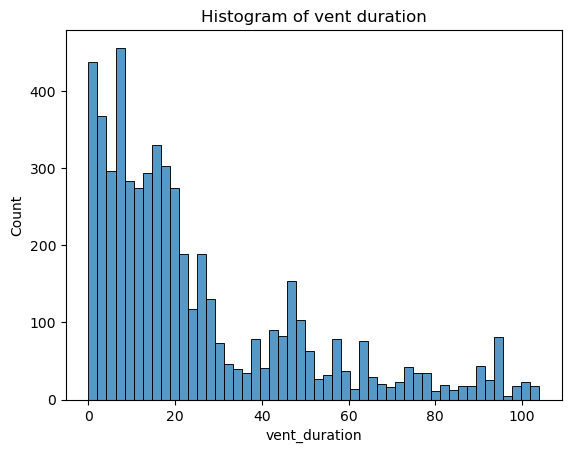

In [53]:
# mean and median vent duration
print('Mean vent duration: ', data_2b['vent_duration'].mean())
print('Median vent duration: ', data_2b['vent_duration'].median())
print('Min duration of vent duration: ', data_2b['vent_duration'].min())
print('Max duration of vent duration: ', data_2b['vent_duration'].max())

# plot the distribution of vent duration
sns.histplot(data_2b, x='vent_duration', bins=50)
plt.title('Histogram of vent duration')

### 4.4. Assess % missing values

In [54]:
# asssess missing values by variables in the dataset

def count_missing(x):
    count = x.isnull().sum()
    percent = round(count / len(x) * 100,1)
    return pd.Series({'missing_count': count, 'missing_percent': percent})

table1 = data_2.agg({col: count_missing for col in data_2.columns[1:]}).T
table1_sorted = table1.sort_values(ascending=True, by='missing_percent')
# save to excel 
table1_sorted.to_excel('missing_values.xlsx') 
print(table1_sorted)

               missing_count  missing_percent
charttime_hrs            0.0              0.0
vent_duration            0.0              0.0
sodium                 185.0              3.0
chloride               204.0              3.3
creatinine             213.0              3.5
glucose                357.0              5.8
calcium                798.0             13.0
hemoglobin            1008.0             16.4
wbc                   1029.0             16.7


### 4.5. Drop columns with > 40% missing values

In [55]:
# Drop columns with missing percentage greater than 40
missing_threshold = 40
cols_to_drop = table1_sorted[table1_sorted['missing_percent'] > missing_threshold].index
data_2b.drop(cols_to_drop, axis=1, inplace=True)

In [56]:
# drop unwanted variables 
data_2b = data_2b.drop(['icu_intime','vent_start', 'vent_end', 'seq', 'seq_n', 'vent_start_hrs', 'charttime'], axis=1)

# move vent_duration to the end of the dataframe
data_2b = data_2b[['stay_id', 'calcium', 'creatinine', 'glucose', 'sodium', 'chloride', 'hemoglobin', 'wbc', 
                            'charttime_hrs', 'vent_duration']]

data_2b.head()

,stay_id,calcium,creatinine,glucose,sodium,chloride,hemoglobin,wbc,charttime_hrs,vent_duration
4830,30004144,8.0,0.7,114.0,135.0,103.0,13.0,5.1,-3.840278,25.0
3369,30004144,6.8,0.7,133.0,135.0,102.0,11.8,4.8,-0.240278,25.0
6602,30005366,8.8,6.7,41.0,139.0,100.0,9.2,9.4,8.550278,6.0
2877,30006983,8.0,0.8,156.0,132.0,102.0,10.1,8.2,-14.611667,49.0
374,30006983,7.1,1.0,89.0,136.0,108.0,NaN,NaN,0.521667,49.0


### 4.6. Data visualisation of the variables (raw data)

In [57]:
# get min and max of calcium, creatinine, glucose, sodium, chloride, hemoglobin, wbc
data_2b[['calcium', 'creatinine', 'glucose', 'sodium', 'chloride', 'hemoglobin', 'wbc']].describe().T

,count,mean,std,min,25%,50%,75%,max
calcium,4760.0,8.415294,0.820425,4.2,7.9,8.4,8.9,12.3
creatinine,5310.0,1.659190,1.868803,0.1,0.8,1.1,1.8,19.7
glucose,5173.0,143.349507,94.246364,30.0,102.0,125.0,159.0,2970.0
sodium,5330.0,137.400938,5.761999,83.0,134.0,138.0,141.0,185.0
chloride,5312.0,101.929029,6.819460,62.0,98.0,102.0,106.0,148.0
hemoglobin,4595.0,10.048596,2.182300,3.9,8.3,9.8,11.5,18.1
wbc,4585.0,11.103468,8.113021,0.1,6.2,9.5,14.0,125.2


Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.


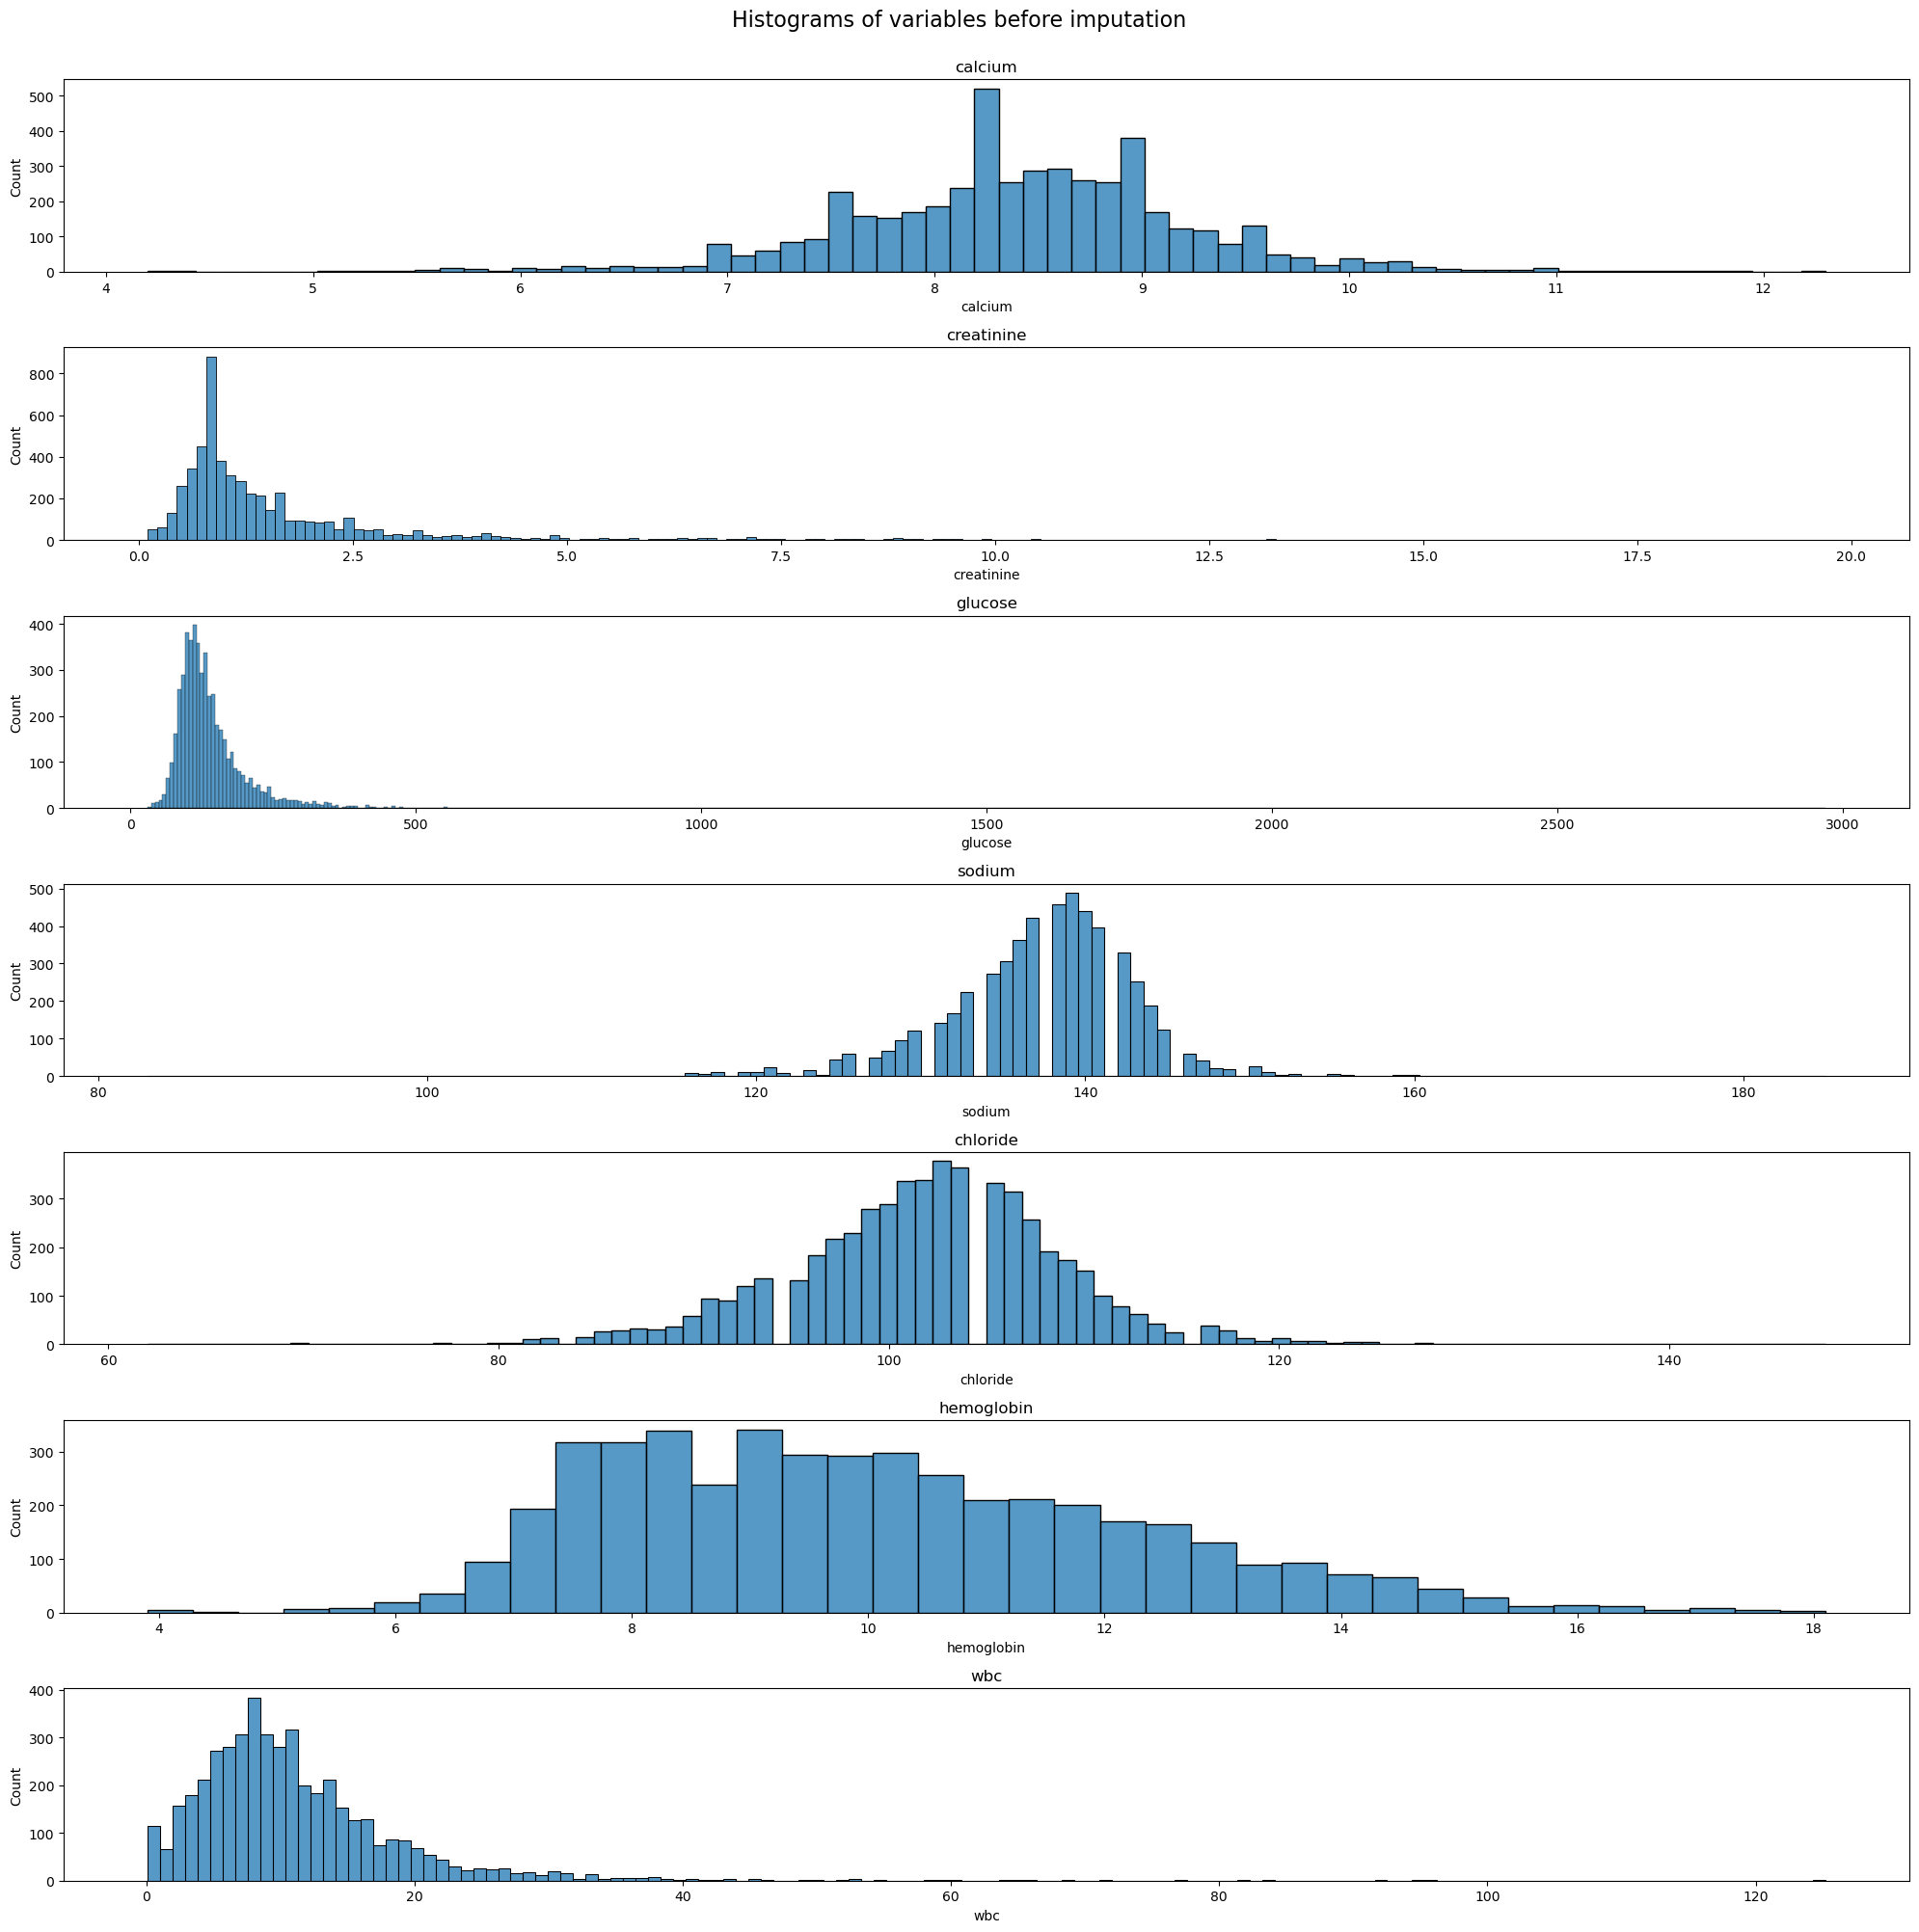

In [58]:
# specify x variables to plot using boxplots
x = data_2b.loc[:, 'calcium':'wbc'].columns

# plot separate histograms for each variable (minus outcome) in a grid
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(20, 20))
fig.suptitle('Histograms of variables before imputation', fontsize=16, y=1.0)
fig.subplots_adjust(hspace=0.5, wspace=0.5) #adjust space between the plots
for i, ax in enumerate(axes.flatten()):
    if i < 7:
        sns.histplot(x=x[i], data=data_2b, ax=ax,palette='Set2')
        ax.set_title(x[i])
        ax.set_xlabel(x[i])
        ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

### *4.7. Split the dataset, impute and scale**

In [59]:
## create the functions for median impute and min max 
# Median impute function based on scikit package
def imputeMedian(dataframe):
    numeric_cols = dataframe.select_dtypes(include=np.number).columns.tolist()
    df = dataframe.copy()
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    df[numeric_cols] = imp_median.fit_transform(df[numeric_cols])
    return df

# Min Max scaling function based on scikit package
def minMaxScale(dataframe):
    df = dataframe.values
    df = minmax_scale(df, feature_range=(0, 1), axis=0, copy=True)
    # put back the column label
    df = pd.DataFrame(df, columns = list(dataframe.columns))
    return df

In [60]:
# Get all unique patients 
unique_values = data_2b['stay_id'].unique().tolist()

# Set the random seed for reproducibility
np.random.seed(42)

# Randomly split 70% of the unique values into a train list and the remaining 30% into a test list
train_size = int(0.7 * len(unique_values))
train = np.random.choice(unique_values, size=train_size, replace=False).tolist()
test = [value for value in unique_values if value not in train]

# Split the DataFrame into train and test DataFrames based on the values of stay_id
train_90_df = data_2b[data_2b['stay_id'].isin(train)].reset_index(drop = True).sort_values(['stay_id', 'charttime_hrs'])
test_90_df = data_2b[data_2b['stay_id'].isin(test)].reset_index(drop = True).sort_values(['stay_id', 'charttime_hrs'])

# Median impute for train. Median impute for test
train_90_df = imputeMedian(train_90_df)
test_90_df = imputeMedian(test_90_df)

#number of patients and records in train set
print('Number of patients train set:', train_90_df['stay_id'].nunique())
print('Number of records train set:', train_90_df.shape[0])
# mean, median, and range of vent_duration in train set for unique patients
print('Mean of vent_duration train set:', train_90_df['vent_duration'].mean())
print('Median of vent_duration train set:', train_90_df['vent_duration'].median())
print('Range of vent_duration train set:', train_90_df['vent_duration'].min(), train_90_df['vent_duration'].max())

# number of patients and records in the test set
print('Number of patients test set:', test_90_df['stay_id'].nunique())
print('Number of records test set:', test_90_df.shape[0])
# mean, median, and range of vent_duration in test set for unique patients
print('Mean of vent_duration test set:', test_90_df['vent_duration'].mean())
print('Median of vent_duration test set:', test_90_df['vent_duration'].median())
print('Range of vent_duration test set:', test_90_df['vent_duration'].min(), test_90_df['vent_duration'].max())

# Min Max scaling for train. Min Max scaling for test
train_90_df_scaled = minMaxScale(train_90_df)
test_90_df_scaled = minMaxScale(test_90_df)

print('Train_100 DataFrame:')
print(train_90_df)
print()
print('Train_100 Min Max scaled DataFrame:')
print(train_90_df_scaled)
print()

print('Test_100 DataFrame:')
print(test_90_df)
print()
print('Test_100 Min Max scaled DataFrame:')
print(test_90_df_scaled)

# i want to save train and test datasets with stay id into excel file
train_90_df.to_excel('train_df.xlsx')
test_90_df.to_excel('test_df.xlsx')

Number of patients train set: 1103
Number of records train set: 3623
Mean of vent_duration train set: 25.22098629130168
Median of vent_duration train set: 17.5
Range of vent_duration train set: 0.016666667 104.0
Number of patients test set: 474
Number of records test set: 1877
Mean of vent_duration test set: 25.327011188128395
Median of vent_duration test set: 15.0
Range of vent_duration test set: 0.033333333 104.0
Train_100 DataFrame:
         stay_id  calcium  creatinine  glucose  sodium  chloride  hemoglobin  \
0     30004144.0      8.0         0.7    114.0   135.0     103.0        13.0   
1     30004144.0      6.8         0.7    133.0   135.0     102.0        11.8   
2     30006983.0      8.0         0.8    156.0   132.0     102.0        10.1   
3     30006983.0      7.1         1.0     89.0   136.0     108.0         9.9   
4     30023204.0      8.2         1.6    124.0   130.0     100.0         8.3   
...          ...      ...         ...      ...     ...       ...         ...   


### **4.8. Run the model**

1. use scaled x data and  y data [ as per joseph's codes]

In [61]:
x_train_90 = train_90_df[['calcium', 'creatinine', 'glucose', 'sodium', 'chloride', 'hemoglobin', 'wbc', 'charttime_hrs' ]]
y_train_90 = train_90_df['vent_duration']

x_test_90 = test_90_df[['calcium', 'creatinine', 'glucose', 'sodium', 'chloride', 'hemoglobin', 'wbc', 'charttime_hrs']]
y_test_90 = test_90_df['vent_duration']

# Define the parameters for the XGBoost model
params = {
    'objective': ['reg:squarederror'],   # Use mean squared error as the objective function
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'alpha': [1, 5, 10],
    'n_estimators': [100, 200, 300]
}

# Create  XGBoost model
model = xgb.XGBRegressor()

# Create GridSearchCV function
cv=TimeSeriesSplit()
grid_search = GridSearchCV(estimator=model, param_grid=params, cv=cv)

# create pipeline to scale the data using min max scaler and use grid search to find the best parameters
pipeline = Pipeline(steps=[('scaler', MinMaxScaler()), ('xgb', grid_search)])

regressor = TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())

# Fit the regressor on the training data
regressor.fit(x_train_90, y_train_90)

# Get the best parameters from the grid search object of the pipeline
best_params = regressor.regressor_.named_steps['xgb'].best_params_

# Print the best parameters
print("Best parameters:", best_params)

# Make predictions on the test set using the best model
y_pred_90 = regressor.predict(x_test_90)
y_pred_inverse_90 = regressor.transformer_.inverse_transform(y_pred_90.reshape(-1, 1))

scaler = MinMaxScaler()
scaler.fit(y_test_90.values.reshape(-1, 1))
y_test_transformed_90 = scaler.transform(y_test_90.values.reshape(-1, 1))
y_pred_inverse_90 = scaler.inverse_transform(y_test_transformed_90)

# Evaluate model performance at record level
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_90, y_pred_90))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_90, y_pred_90))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_90, y_pred_90)))
print( 'R2:', metrics.r2_score(y_test_90, y_pred_90))

print('RMSE = ' + str(mean_squared_error(y_test_90, y_pred_90, squared = False)))

NameError: name 'TransformedTargetRegressor' is not defined

   vent_duration  pred_median  pred_lower  pred_upper
0           6.00    39.816788   10.675882   60.824461
1          20.45    23.706381    7.085282   48.546895
2          20.45    23.921633    6.043693   57.717085
3          20.45    26.089731    7.070321   53.269017
4          20.45    24.908451    7.016405   47.616382
Mean Absolute Error: 19.508293562411772
Mean Squared Error: 683.372430711306
Root Mean Squared Error: 26.14139305223243
R2: -0.02399476807182488
RMSE = 26.14139305223243


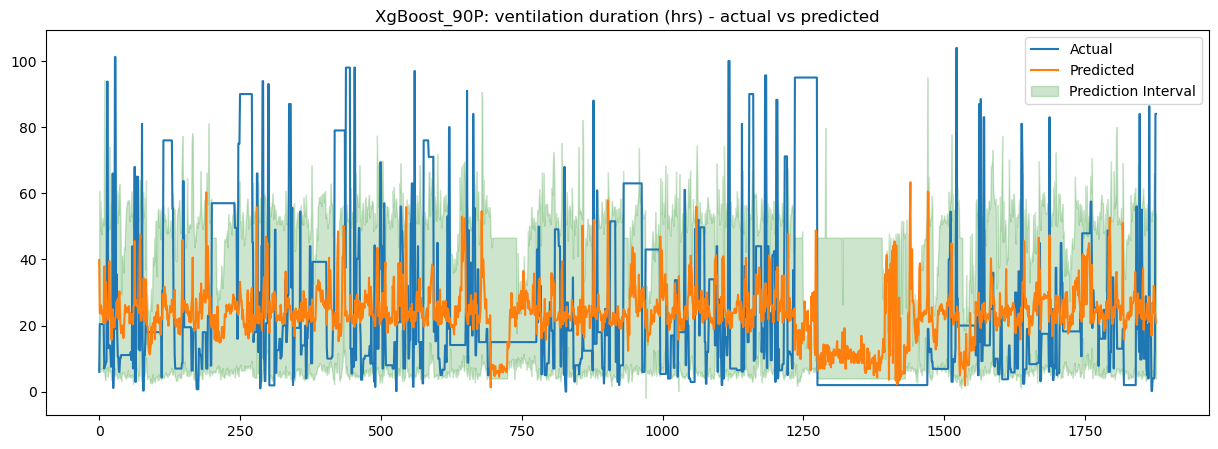

In [62]:
alpha = 0.1

## Predict lower bound
lower_pipeline = Pipeline([('scaler', MinMaxScaler()), ('lower_model', GradientBoostingRegressor(loss="quantile", alpha=alpha, n_estimators=100, max_depth=10))])

## Predict upper bound
upper_pipeline = Pipeline([('scaler', MinMaxScaler()), ('upper_model', GradientBoostingRegressor(loss="quantile", alpha=1-alpha, n_estimators=100, max_depth=10))])

## Predict median
median_pipeline = Pipeline([('scaler', MinMaxScaler()), ('median_model', xgb.XGBRegressor(objective='reg:squarederror', learning_rate=best_params['learning_rate'], max_depth=best_params['max_depth'], alpha=best_params['alpha'], n_estimators=best_params['n_estimators']))])

lower_pipeline.fit(x_train_90, y_train_90)
upper_pipeline.fit(x_train_90, y_train_90)
median_pipeline.fit(x_train_90, y_train_90)

pred_lower = lower_pipeline.predict(x_test_90)
pred_upper = upper_pipeline.predict(x_test_90)
pred_median = median_pipeline.predict(x_test_90)

predictions_90 = pd.DataFrame(y_test_90)
predictions_90['pred_median'] = pred_median
predictions_90['pred_lower'] = pred_lower
predictions_90['pred_upper'] = pred_upper
print(predictions_90.head())

# Evaluate model performance at record level
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_90, pred_median))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_90, pred_median))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_90, pred_median)))
print('R2:', metrics.r2_score(y_test_90, pred_median))

print('RMSE = ' + str(mean_squared_error(y_test_90, pred_median, squared=False)))

# Plot expected vs actual with upper and lower bounds
plt.figure(figsize = (15, 5))
plt.plot(y_test_90, label='Actual')
plt.plot(pred_median, label='Predicted')
plt.fill_between(y_test_90.index, pred_lower, pred_upper, alpha=0.2, color='green', label='Prediction Interval')
plt.title("XgBoost_90P: ventilation duration (hrs) - actual vs predicted")
plt.legend()
plt.show()

RMSE = 25.7607176419005


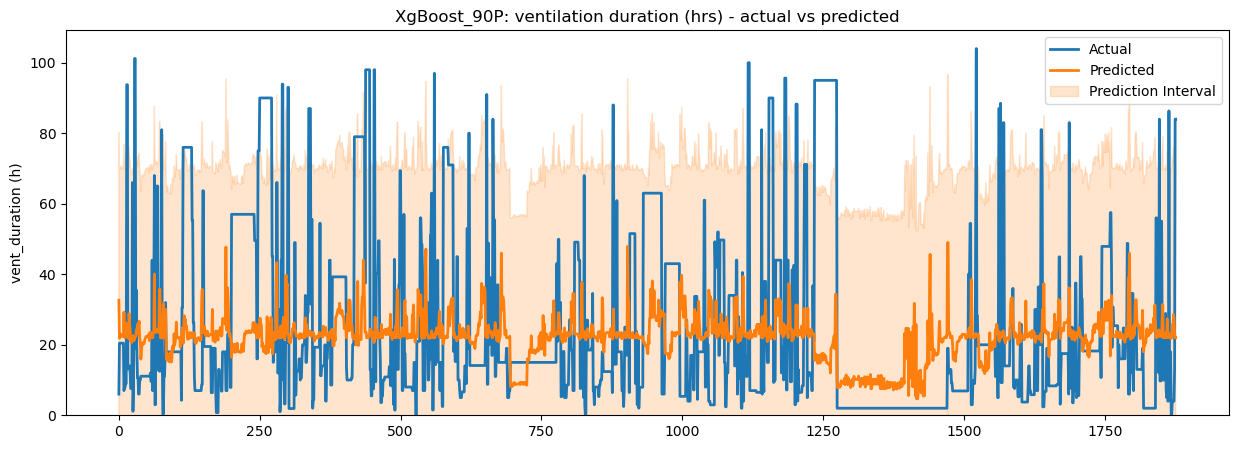

## Feature scores ##

charttime_hrs : 13452.109375
chloride : 11729.4423828125
wbc : 11363.7744140625
creatinine : 8799.2578125
sodium : 6440.90625
glucose : 6215.43310546875
calcium : 5093.43896484375
hemoglobin : 4218.7705078125

## Shapley Additive Explanations - ShAP value ##



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


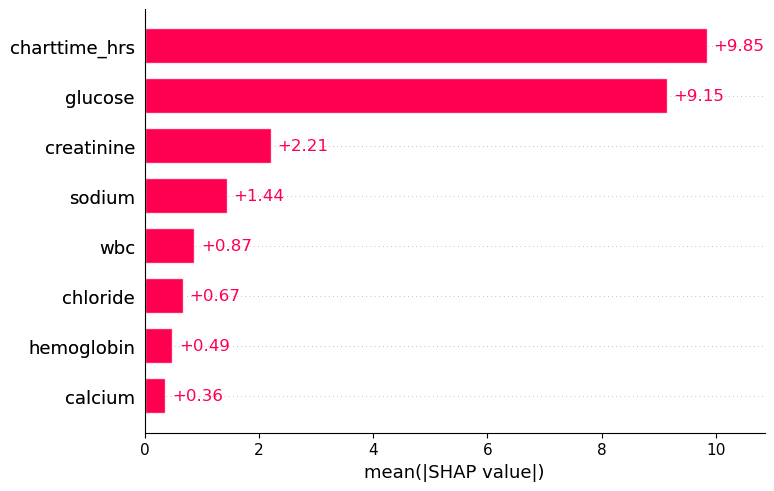

      y_test     y_pred   lower_pi   upper_pi
0       6.00  32.620480 -14.980665  80.221624
1      20.45  21.827065 -25.774080  69.428209
2      20.45  22.254652 -25.346492  69.855796
3      20.45  23.023392 -24.577752  70.624536
4      20.45  22.827707 -24.773437  70.428851
...      ...        ...        ...        ...
1872     NaN  28.609293 -18.991851  76.210437
1873     NaN  27.579227 -20.021917  75.180372
1874     NaN  23.482189 -24.118955  71.083333
1875     NaN  21.966307 -25.634837  69.567451
1876     NaN  21.966307 -25.634837  69.567451

[1877 rows x 4 columns]
      index    y_test     y_pred   lower_pi   upper_pi  index_copy
0       615  0.200000  22.416393 -25.184751  70.017537         615
1      1733  0.216667  25.854353 -21.746791  73.455497        1733
2      1734  0.216667  25.845604 -21.755540  73.446748        1734
3       569  0.266667  29.466085 -18.135059  77.067230         569
4       645  1.000000  31.713608 -15.887536  79.314752         645
...     ...       ...

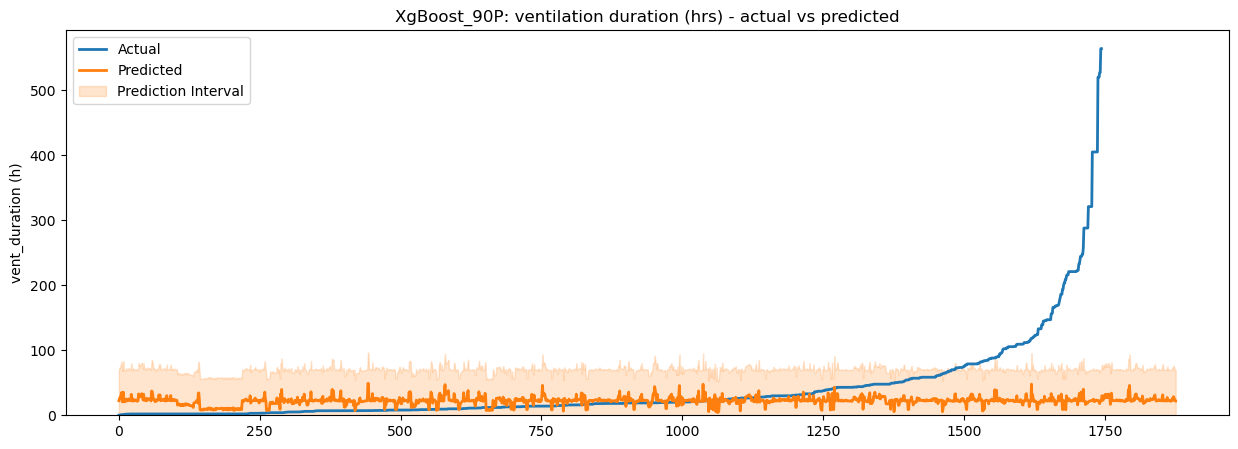

In [64]:
## JL edit


from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.regression import MapieRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from sklearn import set_config

set_config(transform_output="pandas")

best_params = {'alpha': 10, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'objective': 'reg:squarederror'}

## Predict median
median_pipeline = Pipeline([('scaler', MinMaxScaler()), ('median_model', xgb.XGBRegressor(objective='reg:squarederror', learning_rate=best_params['learning_rate'], max_depth=best_params['max_depth'], alpha=best_params['alpha'], n_estimators=best_params['n_estimators']))])
median_pipeline.fit(x_train_90, y_train_90)
pred_median = median_pipeline.predict(x_test_90)


# Evaluate model performance at record level


print('RMSE = ' + str(mean_squared_error(y_test_90, pred_median, squared=False)))

# Plot estimated prediction intervals on test set

mapie = MapieRegressor(
    median_pipeline, method="naive", cv=TimeSeriesSplit(), agg_function=None, n_jobs=-1
)

mapie.fit(x_train_90, y_train_90)
pred_median, y_pis = mapie.predict(x_test_90, alpha=0.05)
coverage = regression_coverage_score(y_test_90, y_pis[:, 0, 0], y_pis[:, 1, 0])
width = regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0])


fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
plt.ylabel("vent_duration (h)")
ax.plot(y_test_90, lw=2, label="Actual", c="C0")
ax.plot(y_test_90.index, pred_median, lw=2, c="C1", label="Predicted")
ax.set_ylim(bottom=0)
ax.fill_between(
    y_test_90.index,
    y_pis[:, 0, 0],
    y_pis[:, 1, 0],
    color="C1",
    alpha=0.2,
    label="Prediction Interval",
)
plt.title("XgBoost_90P: ventilation duration (hrs) - actual vs predicted")
ax.legend()
plt.show()


print("## Feature scores ##")
print()
#‘weight’: the number of times a feature is used to split the data across all trees.
#‘gain’: the average gain across all splits the feature is used in.
feature_importance = median_pipeline[1].get_booster().get_score(importance_type='gain')
feature = median_pipeline[1].get_booster().feature_types

keys = list(feature_importance.keys())
values = list(feature_importance.values())

sorted_feature_importance = []
for i in range(len(feature_importance)):
    sorted_feature_importance.append((keys[i],values[i]))

sorted_feature_importance = sorted(sorted_feature_importance, reverse=True, key=lambda feature: feature[1])
for i in sorted_feature_importance:
    print(i[0],":", i[1])
print()

import shap
print("## Shapley Additive Explanations - ShAP value ##")
print()
explainer = shap.Explainer(median_pipeline[1])
shap_values = explainer(x_test_90)
shap.plots.bar(shap_values, max_display=12) # default is max_display=12

# please replace the y_test, y_pred, and y_pis to match the variable names in your code. 
y_test_df = pd.DataFrame({'y_test': y_test})
y_pred_df = pd.DataFrame({'y_pred': pred_median})
y_pis = y_pis.reshape(1877, 2)
y_pis_df = pd.DataFrame(y_pis, columns=['lower_pi', 'upper_pi'])


# please replace output with a name of your model and the vent_duration percentile. 
output = pd.concat([y_test_df, y_pred_df, y_pis_df], axis=1) 
print(output)
output['index_copy'] = output.index
output = output.sort_values(by=['y_test', 'index_copy']).reset_index().copy(deep=True)
print(output)

# Plot estimated prediction intervals on test set

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
plt.ylabel("vent_duration (h)")
ax.plot(output['y_test'], lw=2, label="Actual", c="C0")
ax.plot(output.index, output['y_pred'], lw=2, c="C1", label="Predicted")
ax.set_ylim(bottom=0)
ax.fill_between(
    output.index,
    output['lower_pi'],
    output['upper_pi'],
    color="C1",
    alpha=0.2,
    label="Prediction Interval")
plt.title("XgBoost_90P: ventilation duration (hrs) - actual vs predicted")
ax.legend()
plt.show()



In [65]:
# please replace the y_test, y_pred, and y_pis to match the variable names in your code. 
y_test_df = pd.DataFrame({'y_test': y_test})
y_pred_df = pd.DataFrame({'y_pred': pred_median})
y_pis = y_pis.reshape(1877, 2)
y_pis_df = pd.DataFrame(y_pis, columns=['lower_pi', 'upper_pi'])

# please replace output with a name of your model and the vent_duration percentile. e.g."randomforest_90_output"
xgb_90_output = pd.concat([y_test_df, y_pred_df, y_pis_df], axis=1)
print(xgb_90_output)
xgb_90_output.to_csv('xgb_90_output.csv')


      y_test     y_pred   lower_pi   upper_pi
0       6.00  32.620480 -14.980665  80.221624
1      20.45  21.827065 -25.774080  69.428209
2      20.45  22.254652 -25.346492  69.855796
3      20.45  23.023392 -24.577752  70.624536
4      20.45  22.827707 -24.773437  70.428851
...      ...        ...        ...        ...
1872     NaN  28.609293 -18.991851  76.210437
1873     NaN  27.579227 -20.021917  75.180372
1874     NaN  23.482189 -24.118955  71.083333
1875     NaN  21.966307 -25.634837  69.567451
1876     NaN  21.966307 -25.634837  69.567451

[1877 rows x 4 columns]


### 5.1. Linear regression

In [ ]:
# collapsed the data to one row per patient
collapsed_data_imputed = data_imputed.groupby('stay_id').median()
collapsed_data_imputed.head()
collapsed_data_imputed.to_excel('collapsed_data_imputed.xlsx')

In [ ]:
# specify x and y variables 

x = collapsed_data_imputed.loc[:, 'calcium':'liver_test']
y = collapsed_data_imputed['vent_duration']

test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = 42)

# run the model 
model = LinearRegression()
model.fit(x_train, y_train)

# predict the test set
y_pred = model.predict(x_test)

# evaluate the model performance 
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print( 'R2:', metrics.r2_score(y_test, y_pred))


### 5.2. Linear mixed effect model

In [66]:
# use data imputed

# specify target variable 
y = data_imputed['vent_duration']
x = data_imputed.drop(['vent_duration'], axis=1)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# define the regression for linear mixed effects model
formula = 'vent_duration ~ calcium + creatinine + glucose + sodium + chloride + hemoglobin + wbc + liver_test + (1|stay_id)'

# fit the mixed effects model on the training set
model = smf.mixedlm(formula, data=x_train.assign(vent_duration=y_train), groups=x_train['stay_id'])
result = model.fit()

# predict the test set using the fitted model
y_pred = result.predict(x_test)

# evaluate the model performance
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print( 'R2:', metrics.r2_score(y_test, y_pred))

NameError: name 'data_imputed' is not defined